# Decision Tree Classifier Model

In [73]:
# Importing all necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# Loading the dataset
new_df = pd.read_csv("final_df4.csv")

In [75]:
new_df.head()

,driver_number,position,points,grid,laps,status,driver_id,constructor_id,fastest_lap_rank,fastest_lap,fastest_lap_time,fastest_lap_speed,raceName,date,season,driverId,dateOfBirth,nationality,driverFullName
0,3,1,10.0,3,58,Finished,michael_schumacher,ferrari,1,1,1,1,Australian Grand Prix,2000-03-12,2000,michael_schumacher,1969-01-03,German,Michael Schumacher
1,4,2,6.0,4,58,Finished,barrichello,ferrari,1,1,1,1,Australian Grand Prix,2000-03-12,2000,barrichello,1972-05-23,Brazilian,Rubens Barrichello
2,9,3,4.0,11,58,Finished,ralf_schumacher,williams,1,1,1,1,Australian Grand Prix,2000-03-12,2000,ralf_schumacher,1975-06-30,German,Ralf Schumacher
3,22,4,3.0,8,58,Finished,villeneuve,bar,1,1,1,1,Australian Grand Prix,2000-03-12,2000,villeneuve,1971-04-09,Canadian,Jacques Villeneuve
4,11,5,2.0,9,58,Finished,fisichella,benetton,1,1,1,1,Australian Grand Prix,2000-03-12,2000,fisichella,1973-01-14,Italian,Giancarlo Fisichella


In [76]:
new_df.isnull().sum()

driver_number        0
position             0
points               0
grid                 0
laps                 0
status               0
driver_id            0
constructor_id       0
fastest_lap_rank     0
fastest_lap          0
fastest_lap_time     0
fastest_lap_speed    0
raceName             0
date                 0
season               0
driverId             0
dateOfBirth          0
nationality          0
driverFullName       0
dtype: int64

In [77]:
# Aggregating season data for each driver
season_summary = new_df.groupby(['season', 'driver_id']).agg(
    total_points=pd.NamedAgg(column='points', aggfunc='sum'),
    total_wins=pd.NamedAgg(column='position', aggfunc=lambda x: (x==1).sum()),  # Count wins
    total_podiums=pd.NamedAgg(column='position', aggfunc=lambda x: (x<=3).sum()),  # Count podiums
    average_finish_position=pd.NamedAgg(column='position', aggfunc='mean'),
    races_participated=pd.NamedAgg(column='raceName', aggfunc='count')  # Count races participated
).reset_index()

# Determining the driver with the highest points in each season as the champion
season_summary['is_champion'] = season_summary.sort_values(['season', 'total_points'], ascending=[True, False]).groupby(['season']).cumcount() == 0

# Converting boolean 'is_champion' to binary format: 1 for champions, 0 for others
season_summary['is_champion'] = season_summary['is_champion'].astype(int)

In [78]:
champion_rows = season_summary[season_summary['is_champion'] == 1]
champion_rows

,season,driver_id,total_points,total_wins,total_podiums,average_finish_position,races_participated,is_champion
14,2000,michael_schumacher,108.0,9,12,5.294118,17,1
38,2001,michael_schumacher,123.0,9,14,3.352941,17,1
60,2002,michael_schumacher,144.0,11,17,1.411765,17,1
84,2003,michael_schumacher,93.0,6,8,4.250000,16,1
109,2004,michael_schumacher,148.0,13,15,2.611111,18,1
122,2005,alonso,133.0,7,15,3.631579,19,1
149,2006,alonso,134.0,7,14,3.555556,18,1
190,2007,raikkonen,110.0,6,12,4.235294,17,1
209,2008,hamilton,98.0,5,10,5.222222,18,1
229,2009,button,95.0,6,9,4.352941,17,1


## Preparing the dataset for model training

In [79]:
# Selecting features and target variable
X = season_summary[['total_points', 'total_wins', 'total_podiums', 'average_finish_position', 'races_participated']]
y = season_summary['is_champion']

In [80]:
# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
# Verifying the size of the splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((459, 5), (115, 5), (459,), (115,))

In [82]:
y_test

475    0
486    0
103    0
216    0
353    0
      ..
437    0
281    0
95     0
553    0
328    0
Name: is_champion, Length: 115, dtype: int64

### Step 1: Model Training

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Step 2: Model Prediction

In [84]:
# Predict the labels for the test set
y_pred = dt_classifier.predict(X_test)

### Step 3: Evaluating the Model

In [85]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Calculating precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision*100:.2f}%")

# Calculating recall
recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall*100:.2f}%")

# Calculating F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1*100:.2f}%")

# Calculating ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc*100:.2f}%")

Confusion Matrix:
 [[109   1]
 [  0   5]]
Accuracy: 99.13%
Precision: 83.33%
Recall Score: 100.00%
F1 Score: 90.91%
ROC-AUC Score: 99.55%


In [99]:
# Function to plot decision tree
def plot_decision_tree(classifier, feature_names, max_depth=None):
    plt.figure(figsize=(20,20))
    tree.plot_tree(classifier, 
                   max_depth=max_depth,
                   feature_names=feature_names, 
                   class_names=['Non-Champion', 'Champion'], 
                   filled=True, rounded=True, 
                   fontsize=14)
    plt.show()
   

# Plotting the full decision tree
plot_decision_tree(dt_classifier, X.columns)

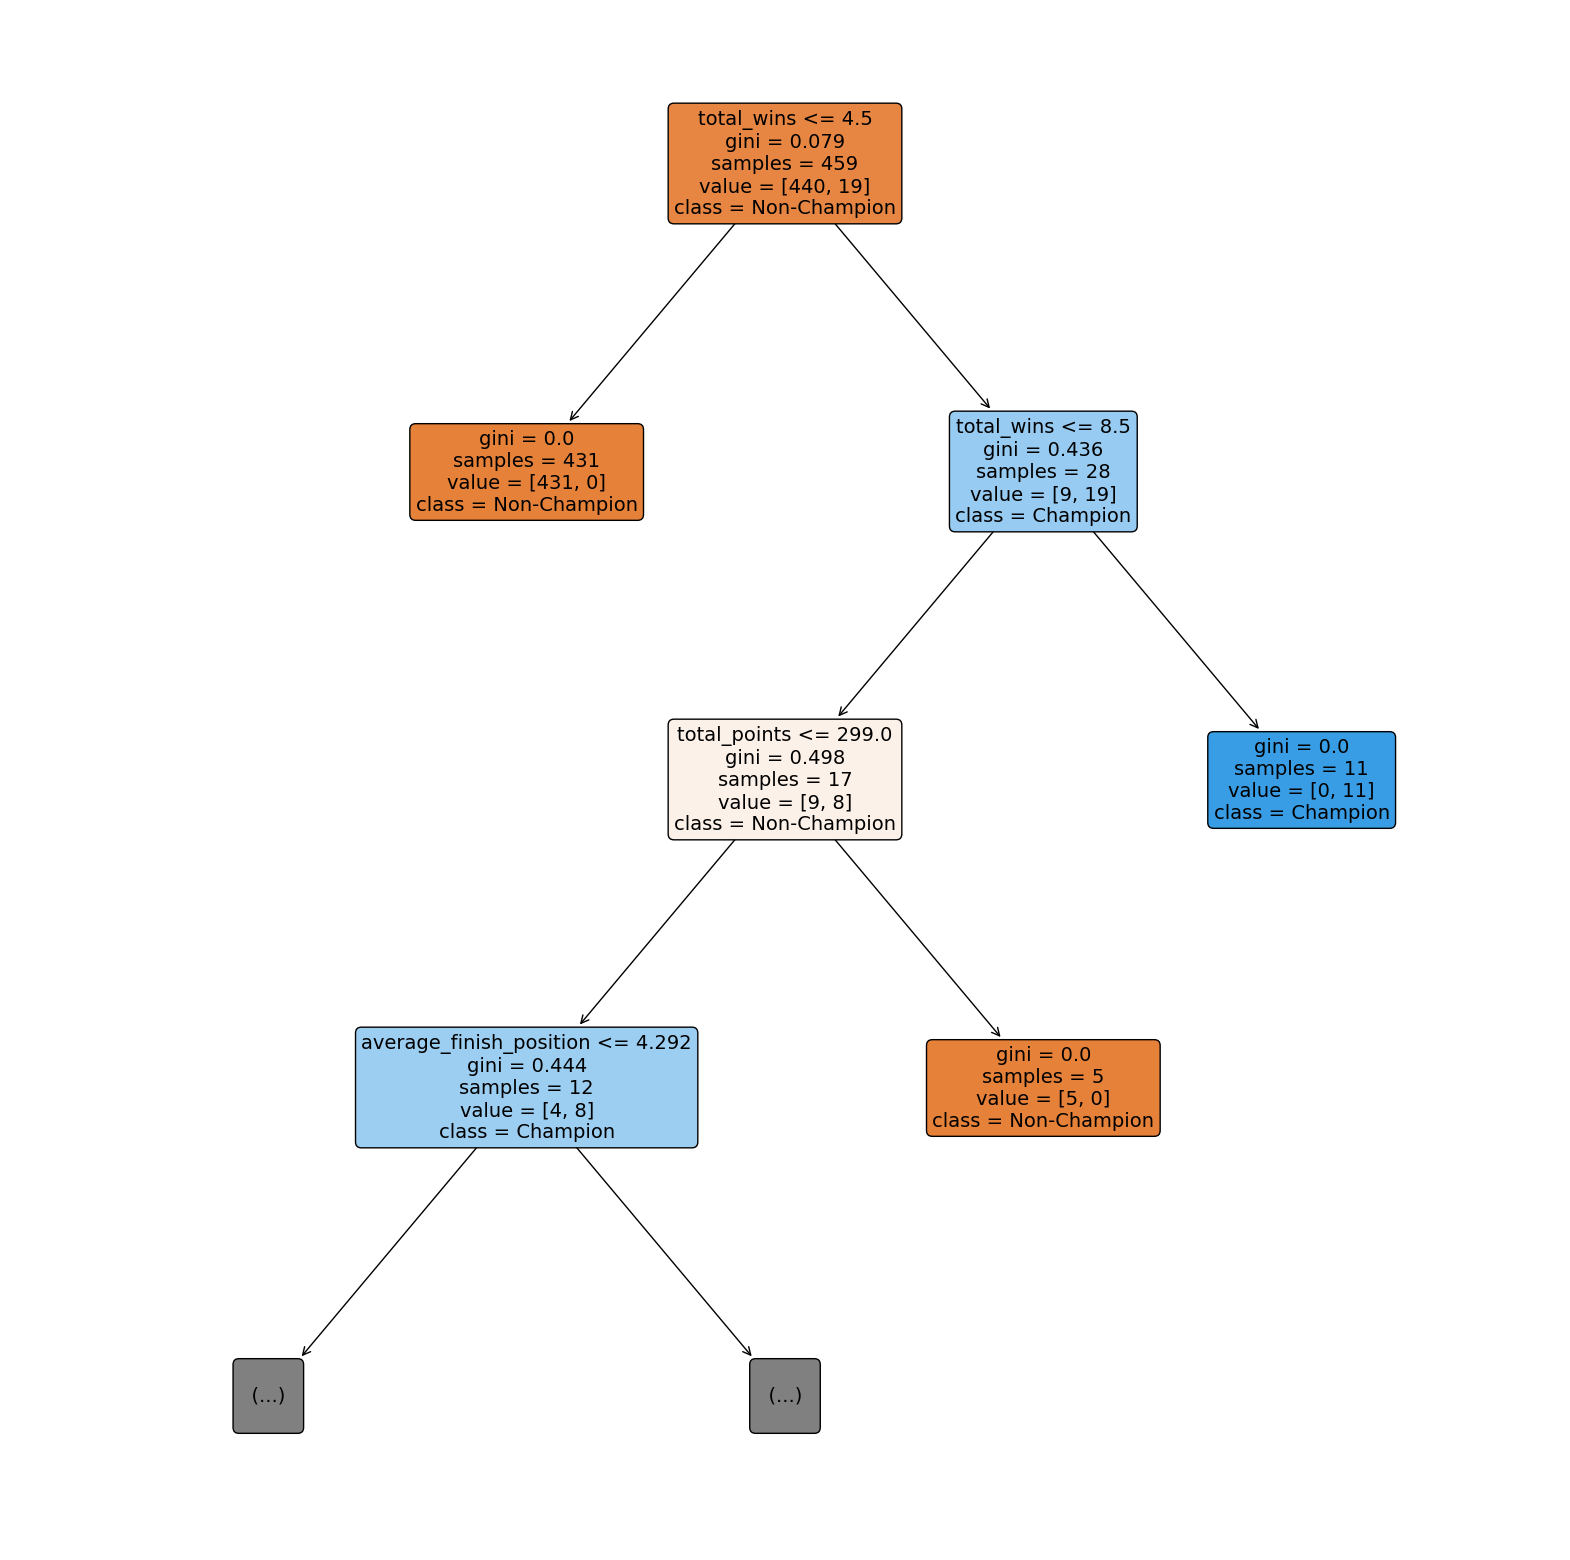

In [98]:
# Plotting pruned decision tree with max_depth=3
plot_decision_tree(dt_classifier, X.columns, max_depth=3)


# Next, we'll plot a tree with max_depth=2 for even simpler interpretation.

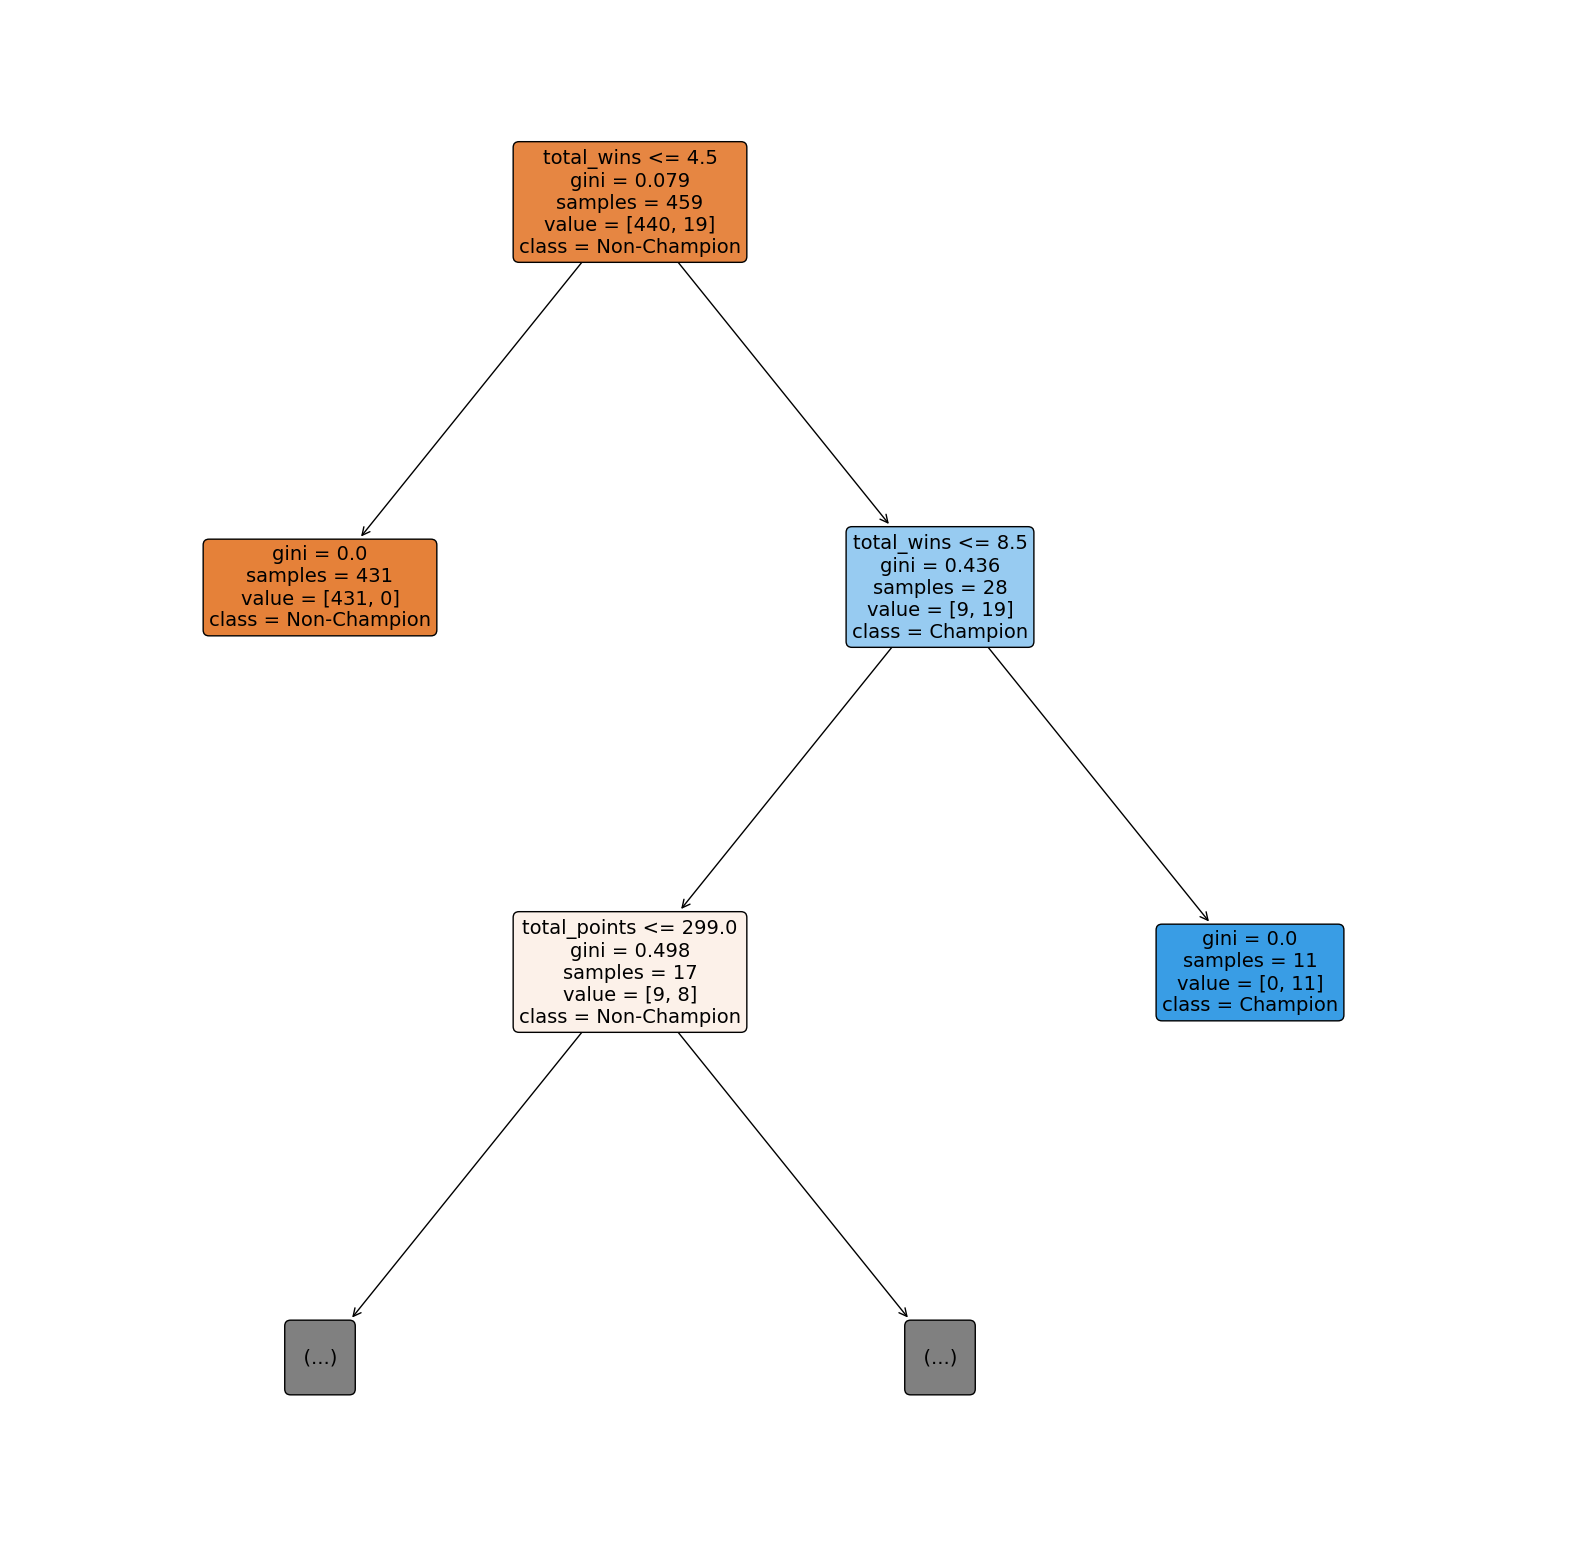

In [100]:
# Plotting pruned decision tree with max_depth=2
plot_decision_tree(dt_classifier, X.columns, max_depth=2)

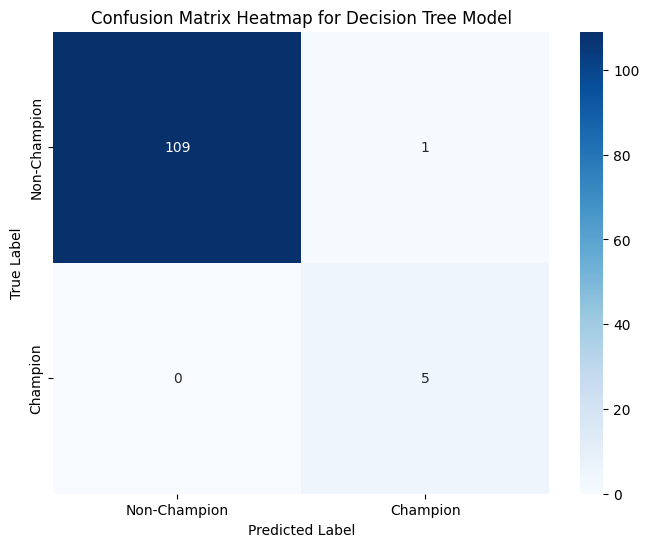

In [89]:
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Champion', 'Champion'], yticklabels=['Non-Champion', 'Champion'])

plt.title('Confusion Matrix Heatmap for Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()